<a href="https://colab.research.google.com/github/awaldis/ai-notes/blob/main/restaurant_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements in Python the restaurant decision tree algorithm from Chapter 19 in:

Russell, Stuart, and Peter Norvig. *Artificial Intelligence: A Modern Approach.* 4th ed. Pearson, 2020.

In [1]:
import pandas as pd
from google.colab import files
from io import StringIO
import math
import graphviz

In [2]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/awaldis/ai-notes/main/restaurant_waiting_examples.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   848  100   848    0     0   3666      0 --:--:-- --:--:-- --:--:--  3670


In [26]:
# Read the downloaded CSV file into a Pandas data frame.
df = pd.read_csv('restaurant_waiting_examples.csv', skipinitialspace=True, keep_default_na=False)

Print the examples.

In [27]:
df

,Alternate,Bar,Fri/Sat,Hungry,Patrons,Price,Raining,Reservation,Type,WaitEstimate,Output
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


In [5]:
def plurality_value(df):
    """
    Determine the most common value in the output column.

    Args:
        df: A pandas data frame.

    Returns:
        A string with the name of the most common attribute value in the output
        column.
    """
    return( df['Output'].value_counts().idxmax())

In [6]:
def entropy_boolean(prob):
    """
    Calculate the information entropy of a boolean random variable.

    Args:
        prob: Probability that the random variable is true (or false, either
        way the entropy is the same).

    Returns:
        Entropy in bits.
    """
    if prob > 0 and prob < 1 :
        return(-(prob * math.log2(prob) + ((1 - prob) * math.log2(1 - prob))))
    return(0)


In [7]:
def remaining_entropy(groups, tot_examples):
    """
    Calculate the remaining entropy if we were to split on the given groups.

    Args:
        groups: A pandas GroupBy object.
        tot_examples: The total number of examples in all the groups.

    Returns:
        The remaining entropy in bits.
    """
    output = 0.0  # Start with a remaining entropy of zero.

    # Now accumulate each groups contribution to the remaining entropy.
    for value, group_df in groups:
        counts_series = group_df['Output'].value_counts()

        if 'Yes' in counts_series.index:
            tot_yes = counts_series['Yes']
        else:
            tot_yes = 0

        tot_examples_this_value = len(group_df)
        output += (tot_examples_this_value/tot_examples) * entropy_boolean(tot_yes/tot_examples_this_value)
    return(output)

In [8]:
def max_info_gain(df):
    """
    Determine the attribute with the maximum information gain.

    Args:
        df: A pandas data frame.

    Returns:
        A string with the name of the column that has the maximum information
        gain.
    """
    # TODO - replace constant 1 with actual entropy calculation.
    total_entropy = 1
    max_info_gain = 0.0
    max_info_gain_column = 'Error'

    for column in df.columns:
        if column == 'Output':
            continue
        info_gain = total_entropy - remaining_entropy(df.groupby(column), len(df))
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            max_info_gain_column = column
    return(max_info_gain_column)

#    print(f"{column} :  %.3f" % info_gain)


In [9]:
class TreeNode:
    """Data and methods for a node in a decision tree."""
    def __init__(self, name, branch_name):
        print(f"Created node for: {name}")
        self.name = name
        self.children = []
        self.branch_name = branch_name # the branch that leads to this node.

    def add_child(self, child_node ):
        self.children.append(child_node)

    def evaluate(self, input_data):
        """
        Use the input vector to walk through the decision tree and find the value
        of the leaf consistent with the input.

        Args:
            input_data: A vector with the data that caller wants to evaluate.
        Returns:
           The predicted output.
    """
        if not self.children:
            return self.name

        for child in self.children:
            if input_data[self.name] == child.branch_name:
                return child.evaluate(input_data)

        return None  # No matching child found

    def create_graph(self, dot, parent_graph_node_name='', level=1, item_num=1):
        """
        Walk through the tree and create a graphical representation with graphviz.

        Args:
            dot: Graphviz directed graph source code object.
            parent_graph_node_name : let root call use default, auto-generated for children
            level : let root call use default, auto-generated for children
            item_num : let root call use default, auto-generated for children
        Returns:
           Graphviz directed graph source code object with the code to render the tree in graphical form.
    """
        #Create a unique name for this graph node.
        this_graph_node_name = f"{level}_{item_num}"

        # Create node on graph for this tree node.
        dot.node(this_graph_node_name, self.name, style='filled', fillcolor='lightblue')

        # Since the root node has no parent this will prevent it from trying to
        # create an edge to it.
        if parent_graph_node_name:
            # Create edge on graph from parent node to this node.
            dot.edge(parent_graph_node_name, this_graph_node_name,
                     label=self.branch_name)

        # Set up varibales for the next level of graph node names.
        level += 1
        item_num = 1

        # Create graph nodes and edges for all the descendents of this node.
        for child in self.children:
             child.create_graph(dot, this_graph_node_name, level, item_num)
             item_num += 1
        return dot


In [10]:
def print_tree(node, level=0):
    indent = "  " * level
    print(f"{indent}Node: {node.name}, Branch: {node.branch_name}")
    for child in node.children:
        print_tree(child, level + 1)

In [11]:
def learn_decision_tree(examples, parent_examples, branch_name):

    if not examples.empty:
        column = examples['Output']

        # Check if all examples have the same output classification.
        if column.nunique() == 1:
             # Get the actual value of the unique classification.
             single_classification = column.iloc[0]
             return(TreeNode(single_classification, branch_name))
    else :
        return(TreeNode(plurality_value(parent_examples), branch_name))

#    if attributes empty...

    most_important_attribute = max_info_gain(examples)

    tree = TreeNode(most_important_attribute, branch_name)

    value_groups = examples.groupby(most_important_attribute)

    for value_name, group_df in value_groups:
        print(value_name)
        group_df_mia_dropped = group_df.drop(columns=most_important_attribute)
        subtree = learn_decision_tree(group_df_mia_dropped, examples, value_name)
        tree.add_child(subtree)

    return(tree)

In [12]:
dec_tree = learn_decision_tree(df, df, 'root')


Created node for: Patrons
Full
Created node for: Hungry
No
Created node for: No
Yes
Created node for: Type
Burger
Created node for: Yes
Italian
Created node for: No
Thai
Created node for: Fri/Sat
No
Created node for: No
Yes
Created node for: Yes
None
Created node for: No
Some
Created node for: Yes


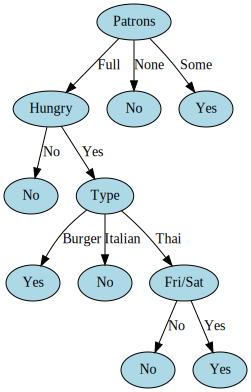

In [13]:
dot = graphviz.Digraph(comment='Restaurant Decision Tree')
dot.attr(rankdir='TB')
dec_tree.create_graph(dot)
#type(dot)

Evaluate the decision tree with each input vector from the training set.  Verify that the calculated output matches the expected output for each example.

In [28]:
for index, row in df.iterrows():
    # Convert the row to a Series
    row_series = row.copy()
    # Remove the last value ("Output")
    row_series = row_series[:-1]
    # Print the modified row
    #print(f"\nModified Row {index}:")
    #print(row_series)
    print(row['Output'],dec_tree.evaluate(row_series))

Yes Yes
No No
Yes Yes
Yes Yes
No No
Yes Yes
No No
Yes Yes
No No
No No
No No
Yes Yes


One error that needs to be fixed is that there is no transition for a French restaurant in the decision tree.  We can stimulate this error by changing the row 4 "Hungry" attribute to "Yes".

In [24]:
test_row = df.iloc[4]
test_row["Hungry"] = 'Yes'
print(dec_tree.evaluate(test_row))

None


# **Archived code snippets below here:**

In [16]:
import os

In [17]:
os.listdir()

['.config', 'restaurant_waiting_examples.csv', 'sample_data']

In [18]:
os.remove('restaurant.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'restaurant.csv'

In [ ]:
uploaded['restaurant.csv']

In [ ]:
df['Output'][4]

In [ ]:
plurality_value(df.iloc[0:11])

In [ ]:
df.iloc[2:5]['Output'].value_counts().idxmax()

In [ ]:
grouped = df.groupby('Patrons')
dfs = {city: group for city, group in grouped}
grouped.groups

In [ ]:
group_df['Output'].value_counts()

In [ ]:
x = grouped.get_group('Full')['Output'].value_counts()
#x['Yes'] + x['No']
x.index

In [ ]:
dfs.keys()

In [ ]:
def remaining_entropy_old(groups, tot_examples):
    for value, group_df in groups:
        print(f"DataFrame for value: {value}")
        counts_series = group_df['Output'].value_counts()
        tot_yes = counts_series['Yes']
        tot_examples_this_value = len(group_df)
        print(tot_yes)
        print(len(group_df))
        print(entropy_boolean(tot_yes/tot_examples_this_value))
        print(tot_examples_this_value/tot_examples)
        print()
        print()

In [ ]:
df.iloc[0:11]

Possibly use Graphviz to visualize tree in the future.

In [ ]:
dot = graphviz.Digraph(comment='The Round Table')

dot.node('A', 'Patrons?')
dot.node('B', 'No')
dot.node('L', 'Yes')
dot.node('C', 'Hungry')
dot.node('D', 'Test')

dot.edge('A', 'B', label='None')
dot.edge('A', 'L', label='Some')
dot.edge('A', 'C', label='Full')
dot.edge('C', 'D', label='New Level')
#dot.edges(['AB', 'AL'])
#dot.edge('B', 'L', constraint='false')

dot